In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent  # Assuming notebook is in experiments/notebooks/
sys.path.insert(0, str(project_root))
print(sys.path)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experiments.analysis_utils.data_processing import read_directory, clean_timesteps_ragequit_loop
from experiments.analysis_utils.metrics import count_ragequit_episodes, calculate_state_durations
from specs.dual_governance.state import State

['/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/miniconda3/envs/radCAD/lib/python312.zip', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/lib-dynload', '', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/site-packages']


In [2]:
path_to_runs = Path("../../results/simulations/rage_quit_loop/")
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(
    path_to_runs.resolve(), pass_directory_name=True
)
timestep_data_df_full["run_id_str"] = timestep_data_df_full["run_id"].astype(str)

In [3]:
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on="run_id")
cleaned_timestep_data_df = clean_timesteps_ragequit_loop(timestep_data_df_full_with_params)

state_timesteps_df = cleaned_timestep_data_df.groupby(["run_id", "dg_state_name"]).size().unstack(fill_value=0)
for dg_state_name in ["Normal", "VetoSignalling", "VetoSignallingDeactivation", "VetoCooldown", "RageQuit"]:
    if dg_state_name not in state_timesteps_df.columns:
        state_timesteps_df[dg_state_name] = 0
state_timesteps_df *= 3 / 24

state_durations_df = calculate_state_durations(cleaned_timestep_data_df)
state_durations_df["duration_days"] = state_durations_df["duration"] * 3 / 24

# Since the simulations are finite in time, we need to calculate if the RageQuit loops are continuing beyond the simulation time
# We do this by checking two conditions:
# 1. The sum of the state durations is equal to the maximum number of timesteps.
#   This works because all the timesteps that do not belong to the RageQuit loop were truncated previously by clean_timesteps_ragequit_loop
# 2. There is at least one RageQuit state in the simulation

max_timesteps = timestep_data_df_full.groupby("run_id").timestep.max().max()

condition_1 = state_durations_df.groupby("run_id").duration.sum() == max_timesteps
condition_2 = state_durations_df.groupby("run_id")["state"].agg(lambda x: "RageQuit" in x.values)

# Multiply the conditions and negate the result
loop_continued = (condition_1 & condition_2)

# Create a DataFrame with "run_id" and "loop_continued"
loop_continued_df = loop_continued.reset_index(name='loop_continued')

In [4]:
ragequit_episodes_df = count_ragequit_episodes(cleaned_timestep_data_df)

starting_balances = (
    timestep_data_df_full_with_params[timestep_data_df_full_with_params["timestep"] == 1]
    .groupby("run_id")["actors_total_balance"]
    .sum()
)
state_timesteps_df_with_params = state_timesteps_df.merge(starting_balances, on="run_id")

state_timesteps_df_with_params = state_timesteps_df_with_params.merge(ragequit_episodes_df, on="run_id").merge(
    start_data_df_full[["run_id", "attacker_funds", "lido_exit_share", "second_seal_rage_quit_support"]], on="run_id"
)
state_timesteps_df_with_params["attacker_share"] = state_timesteps_df_with_params["attacker_funds"] / (
    state_timesteps_df_with_params["attacker_funds"] + 9000000
)
state_timesteps_df_with_params = state_timesteps_df_with_params.merge(loop_continued_df, on="run_id")

state_timesteps_df_with_params["loop_duration"] = state_timesteps_df_with_params["VetoSignalling"] + state_timesteps_df_with_params["VetoSignallingDeactivation"] + state_timesteps_df_with_params["RageQuit"]

In [5]:
# print("Days in each state for each run, number of RageQuit events")
state_timesteps_df_with_params.set_index(['lido_exit_share', 'second_seal_rage_quit_support', 'attacker_share', 'actors_total_balance']).sort_index().loc[:,["ragequit_episodes", "loop_duration", "loop_continued", "Normal", "VetoSignalling", "VetoSignallingDeactivation", "RageQuit", "VetoCooldown", "run_id"]]

ragequit_episodes  \
lido_exit_share second_seal_rage_quit_support attacker_share actors_total_balance                      
0.3             0.05                          0.0600         4500000.0                             1   
                                                             9000000.0                             1   
                                                             18000000.0                            1   
                                              0.1075         4500000.0                             3   
                                                             9000000.0                             3   
                                                             18000000.0                            4   
                                              0.1526         4500000.0                             8   
                                                             9000000.0                             9   
                                                             18000000.0                           11   
                                              0.1955         4500000.0                            24   
                                                             9000000.0                            22   
                                                             18000000.0                           18   
                0.10                          0.0600         4500000.0                             0   
                                                             9000000.0                             0   
                                                             18000000.0                            0   
                                              0.1075         4500000.0                             1   
                                                             9000000.0                             1   
                                                             18000000.0                            1   
                                              0.1526         4500000.0                             1   
                                                             9000000.0                             1   
                                                             18000000.0                            1   
                                              0.1955         4500000.0                             4   
                                                             9000000.0                             4   
                                                             18000000.0                            6   
                                              0.2710         4500000.0                             9   
                                                             9000000.0                            10   
                                                             18000000.0                           14   
                                              0.3440         4500000.0                            22   
                                                             9000000.0                            19   
                                                             18000000.0                           14   

                                                                                   loop_duration  \
lido_exit_share second_seal_rage_quit_support attacker_share actors_total_balance                  
0.3             0.05                          0.0600         4500000.0                    68.250   
                                                             9000000.0                    77.250   
                                                             18000000.0                   95.250   
                                              0.1075         4500000.0                   185.125   
                                                             9000000.0                   208.125   
                                                      

In [6]:
run_id = 3
print(
    f"Example run with RageQuit Loop, where attackers have {state_timesteps_df_with_params[state_timesteps_df_with_params.run_id == run_id].attacker_share.min():.3f} share of total pool"
)
state_durations_df[state_durations_df["run_id"] == run_id]

Example run with RageQuit Loop, where attackers have 0.060 share of total pool


,run_id,state,duration,duration_days
9,3,Normal,5,0.625
10,3,VetoSignalling,360,45.000
11,3,RageQuit,115,14.375
12,3,VetoSignalling,46,5.750
13,3,VetoSignallingDeactivation,25,3.125


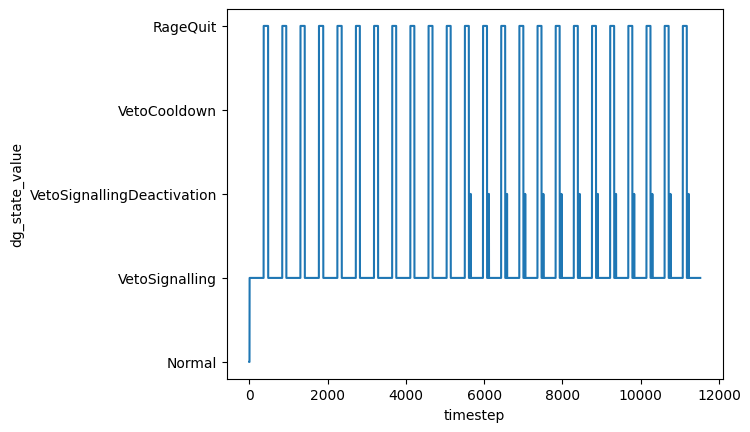

In [7]:
sns.lineplot(data=timestep_data_df_full[timestep_data_df_full["run_id"] == 5], x="timestep", y="dg_state_value")
plt.yticks([1, 2, 3, 4, 5])
from matplotlib.ticker import FuncFormatter

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{State(x).name}"))